# Notes

Task: Please review the dataset and start outlining the way you would go about the model-building process with the goal of predicting the probability that a player will win a foul on his possession after he receives or recovers the ball.

Notes:
- In the case of a received pass, the previous event (related event) is to be inspected for the pass attributes (location, length, highness...)
- Aggregated player data could be useful (ratio of passes under pressure signaling if he waits for pressure, dribbles per match)
- Referees are really important
- Home or away
- (Game state)


Cooridnates
- I suspect the origo is different for the two teams competing

# Dependencies

In [1]:
import pandas as pd
import numpy as np

from typing import Tuple
from mplsoccer import VerticalPitch, add_image, FontManager, Sbopen, Pitch

# Data

## Data import

In [2]:
df_event = pd.read_csv('/Users/thomasregos/Owny/Assessment/Swish_Take_Home_Assessment_Data_-_EPL/epl_event_data_15.csv',
                    #    nrows=10000
                       )

df_matches = pd.read_csv('/Users/thomasregos/Owny/Assessment/Swish_Take_Home_Assessment_Data_-_EPL/epl_matches_15.csv')

## Data exploration

In [3]:
df_matches.columns

Index(['Unnamed: 0', 'match_id', 'match_date', 'kick_off', 'home_score',
       'away_score', 'match_status', 'last_updated', 'match_week',
       'competition.competition_id', 'competition.country_name',
       'competition.competition_name', 'season.season_id',
       'season.season_name', 'home_team.home_team_id',
       'home_team.home_team_name', 'home_team.managers',
       'away_team.away_team_id', 'away_team.away_team_name',
       'away_team.managers', 'competition_stage.id', 'competition_stage.name',
       'stadium.id', 'stadium.name', 'referee.id', 'referee.name',
       'referee.country.id', 'referee.country.name'],
      dtype='object')

In [4]:
df_event['type.name'].unique()

array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt*', 'Carry',
       'Pressure', 'Dispossessed', 'Duel', 'Shot', 'Block', 'Goal Keeper',
       'Ball Recovery', 'Miscontrol', 'Clearance', 'Dribbled Past',
       'Dribble', 'Interception', 'Foul Committed', 'Foul Won',
       'Half End', 'Substitution', 'Injury Stoppage', 'Tactical Shift',
       'Shield', '50/50', 'Offside', 'Error', 'Bad Behaviour',
       'Referee Ball-Drop', 'Own Goal Against', 'Own Goal For',
       'Player Off', 'Player On'], dtype=object)

In [5]:

# n = 1528

# bbb = df_event.iloc[max(n - 10, 0): min(n + 11, len(df_event))]

# Training dataset
The main goal is to create a table where all the starting actions of a mini possession is listed. Mini possession is part of a possession where all the actions are taken by the same player. These events then should be ammended with a target variable which signals that a mini possession contained a foul won or not. Additional variables are later added for more info about the event.

## Skeleton of the training dataset



Each row should be a mini possession of the player, which starts by receiving or recovering the ball. In order to identify the mini possessions a number is assigned to a player's events inside a possession. This number is different for all of the player's mini possessions. So if he received a pass then carried the ball and passed it, it will receive a number and then if inside the possession he receives the ball again these events will have a different number. Combining these mini possession IDs with the possession ID, match ID and the player ID all the mini possession can be identified.



Notes:

- Mini possessions have to be detected at player level
    - First the sub possession should be calculated and then create a matchid_possession_subpossession 
- For our purpose those mini possessions are relevant that start with ball recovery or received pass 
    - Valid mini possessions are identified by type.name as we have a better control this way. For detecting ball recovery it would be an option to check if the possession_team.name has changed but there are examples of making a recovery winning a foul and the data still says that the possession is on the other team (id: 7317). As the possession mechanics are not clear I will use type.name.
    - Sometimes a possession starts with a 'Foul Won'. I don't think we should include those as the probability of these possessions to contain a 'Foul Won' is certain.
    - type.name == 'Ball Recovery'
    - pass.type.name = 'Recovery'
        - If a recovery is also a pass. These could be also relevant if the pass provokes a hand ball.
    - type.name == 'Ball Receipt*'
        - Beware, there is an event for receiving an incomplete pass which was already intercepted, with type.name = 'Ball Receipt*'
        - ball_receipt.outcome.id = 9 (incomplete pass that was actually not received)
        - These should be None as they are not real mini possessions
    - type.name == 'Interception'
        - Although it is not a ball recovery by name and no instruction is given to include these, but I think this action recovers the ball in open play so it satisfies our criteria
    - type.name == 'Duel'
        - Although it is not a ball recovery by name and no instruction is given to include these, but I think this action recovers the ball in open play so it satisfies our criteria
    - type.name == 'Goal Keeper'
        - Although it is not a ball recovery by name and no instruction is given to include these, but I think this action recovers the ball in open play so it satisfies our criteria
    - type.name == 'Clearance'
        - Although it is not a ball recovery by name and no instruction is given to include these, but I think this action recovers the ball in open play so it satisfies our criteria
    - type.name == 'Block'
        - Although it is not a ball recovery by name and no instruction is given to include these, but I think this action recovers the ball in open play so it satisfies our criteria
- Getting rid of Pressure events
    - From our perspective it is enough to know if certain events were under pressure or not and it is reflected in the 'under_pressure' column
    - Getting rid of the individual 'Pressure' events enables us to have a chronological event chain for player possessions
- Getting rid of 'Foul Committed' events
    - type.name == 'Foul Committed'
    - Foul won is enough for our purpose
- Foul won
    - type.name == 'Foul Won'
    - It can happen that a player not having the ball draws the foul. (index: 646)
    - It can happen that a player having the ball commits a foul. (index: 898)
    - It might happen that a foul is won but the play goes on as I saw several examples of winning a foul and then having a carry event that starts at the same location. It is supported by the fact that this carry and the subsequent events are not labeled as 'play_pattern.name' = 'From Free Kick'. These could be when the referee plays advantage. As there is no info about how to consider these fouls that were won but ultimately not resulted in a freekick I will count them as a foul won. (index: 1012)


In [6]:
# Mini possessions
df_filtered = df_event.copy()

# - Getting rid of unneccessary rows
notvalid_start_events = ['Foul Committed', 'Pressure', 'Dribbled Past']
df_filtered = df_filtered[~df_filtered['type.name'].isin(notvalid_start_events)]

# - calculating mini_possessions inside possessions
# not perfect but we will be able to get a unique identifier for each mini possession
df_filtered['poss_mini'] = (
    df_filtered.groupby('possession')['player.id']
    .transform(lambda x: x.ne(x.shift()).cumsum())
)

# - adding unique identifier for mini possessions
df_filtered['poss_mini_id'] = df_filtered[['match_id', 'player.id', 'possession', 'poss_mini']].fillna('_').apply(lambda row: '_'.join(row.apply(lambda x: str(int(x)) if isinstance(x, float) and x.is_integer() else str(x))), axis=1)


# - identifying mini possessions that started with a ball recovery or a ball receipt
valid_start_events = ['Ball Recovery', 'Ball Receipt*', 'Duel', 'Interception', 'Goal Keeper', 'Clearance', 'Block']

df_filtered['valid_start'] = df_filtered.groupby('poss_mini_id')['type.name'].transform(
    lambda x: 1 if x.isin(valid_start_events).any() or (df_filtered.loc[x.index, 'pass.type.name'] == 'Recovery').any() else 0
)

# - identifying mini possession that contains Foul Won
df_filtered['contains_foulwon'] = df_filtered.groupby('poss_mini_id')['type.name'].transform(lambda x: 1 if 'Foul Won' in x.values else 0)


# - preserving only starting events of mini possessions
mask = ((df_filtered['valid_start']==1))
df_filtered = df_filtered[mask]

df_training_full = df_filtered.drop_duplicates(subset=['poss_mini_id'], keep='first')


## Additional info about the events



I only use data that is available at the time of the ball recovery or pass reception.

### Info about prior events

#### Checking the type of related events

Info about opponent or teammate passes might be useful.

Notes:
- Most of the related events are passes from a teammate or an opponent pass.
- Pressures are also above 1% but this info is reflected on the starting event's record itself.
- Opponent shots are around 2% of the whole related events, and they might be interesting for niche events, but not used at this time.


In [7]:
df_filtered_event = df_event.copy()
df_filtered = df_training_full.copy()

df_filtered_event['seconds_elapsed'] = df_filtered_event['minute'] * 60 + df_filtered_event['second']
df_filtered['seconds_elapsed'] = df_filtered['minute'] * 60 + df_filtered['second']

# Expanding related events into separate rows
df_exploded = df_filtered.assign(related_events=df_filtered['related_events'].str.split(', ')).explode('related_events')

# Merging with original data to get the related event details
df_merged = df_exploded.merge(df_filtered_event, left_on='related_events', right_on='id', how='left', suffixes=['', '_related'])

# Keeping only related events that happened before
df_valid = df_merged[df_merged['seconds_elapsed_related'] < df_merged['seconds_elapsed']]

# Differentiating between opponent and own related events
df_valid.loc[df_valid['team.id'] != df_valid['team.id_related'], 'type.name_related'] = (df_valid['type.name_related'].astype(str) + "_opp")

# Ratio of certain event types in the valid related events
rel_counts = df_valid['type.name_related'].value_counts(normalize=True)
print(rel_counts)


type.name_related
Pass             0.790014
Pass_opp         0.152689
Pressure_opp     0.038874
Shot_opp         0.018171
Shot             0.000134
Carry_opp        0.000072
Ball Receipt*    0.000045
Name: proportion, dtype: float64


#### Including data about related events

In [8]:
# preserving only the desired type of related events
df_valid = df_valid[df_valid['type.name_related'].isin(['Pass', 'Pass_opp'])]

# renaming important columns
df_valid = df_valid.rename(columns={'related_events': 'relevant_related_id'})

In [9]:

df_filtered = df_training_full.copy()

# checking if there are no two relevant related events for an event
print(df_valid['id'].nunique() == df_valid.shape[0])

# merging the relevant related event info to the training dataset
df_filtered = df_filtered.merge(df_valid[['seconds_elapsed', 'type.name_related', 'relevant_related_id', 'id']], how='left', on='id')

# merging on additional info of the relevant event from the main data
relevant_event_cols = [
    'location',
    'under_pressure',
    'play_pattern.id',
    'team.id',
    'position.id',
    'pass.length',
    'pass.angle',
    'pass.height.id',
    'pass.body_part.id',
    'pass.type.id',
    'pass.end_location',
    ]

df_filtered = df_filtered.merge(df_event[relevant_event_cols + ['id']],
                                how='left',
                                left_on='relevant_related_id', right_on='id',
                                suffixes=['', '_related'])

# getting dummies for 'type.name_related'
df_filtered = pd.concat([df_filtered, pd.get_dummies(df_filtered['type.name_related'], prefix='type.name_related', dtype=int)], axis=1)
df_filtered = df_filtered.drop(columns=['type.name_related'])


df_training_full = df_filtered.copy()


True


### Info about the teams, the match and the referee

I include info about the team's manager, the opponent team's manager, the referee and the venue.

Notes:
 - Many columns could be useful but contain the same value like 'competition.country_name' or 'referee.country.id'.

In [10]:
df_filtered = df_training_full.copy()
df_filtered_matches = df_matches.copy()


# - creating manager sub table
# -- there is an error which is manually checked and corrected
# source: https://www.soccerbase.com/teams/team.sd?team_id=2513&teamTabs=managers
# on matchid: 3754151 the correct manager for home_team.managers: 3626, Francesco Guidolin, NA, 1955-10-03, 112, Italy
df_filtered_matches.loc[df_filtered_matches['match_id'] == 3754151, 'home_team.managers'] = '3626, Francesco Guidolin, NA, 1955-10-03, 112, Italy'
# on matchid: 3753988 the correct manager for away_team.managers: 3626, Francesco Guidolin, NA, 1955-10-03, 112, Italy
df_filtered_matches.loc[df_filtered_matches['match_id'] == 3753988, 'away_team.managers'] = '3626, Francesco Guidolin, NA, 1955-10-03, 112, Italy'

# -- Splitting the column into multiple parts
exploded_managers = ['manager_id', 'manager_name', 'manager_nickname', 'manager_birthdate', 'manager_countryid', 'manager_countryname']
df_filtered_matches[[f"{i}_home" for i in exploded_managers]] = df_filtered_matches['home_team.managers'].str.split(', ', expand=True)
df_filtered_matches[[f"{i}_away" for i in exploded_managers]] = df_filtered_matches['away_team.managers'].str.split(', ', expand=True)


# - aggregating 

exploded_managers_mini = ['manager_id', 'manager_birthdate', 'manager_countryid']
relevant_matchinfo_cols = [
    'home_team.home_team_id',
    'away_team.away_team_id',
    'stadium.id',
    'referee.id',
    # 'match_date'
] + [f"{i}_home" for i in exploded_managers_mini] + [f"{i}_away" for i in exploded_managers_mini]

df_filtered = df_filtered.merge(df_filtered_matches[relevant_matchinfo_cols + ['match_id']],
                                how='left',
                                on='match_id')

# Home or away team
df_filtered['played_at_home'] = np.where(df_filtered['team.id'] == df_filtered['home_team.home_team_id'], 1, 0)

# Opponent
df_filtered['opponent_team.id'] = np.where(df_filtered['team.id'] == df_filtered['home_team.home_team_id'], df_filtered['away_team.away_team_id'], df_filtered['home_team.home_team_id'])

# Opponent Manager
opp_manager_exploded = [f"{i}_opponent" for i in exploded_managers_mini]
df_filtered[opp_manager_exploded] = np.where(df_filtered['played_at_home'].values[:, None] == 0,
                                             df_filtered[[f"{i}_home" for i in exploded_managers_mini]].to_numpy(),
                                             df_filtered[[f"{i}_away" for i in exploded_managers_mini]].to_numpy())

# Manager
own_manager_exploded = [f"{i}_own" for i in exploded_managers_mini]
df_filtered[own_manager_exploded] = np.where(df_filtered['played_at_home'].values[:, None] == 1,
                                             df_filtered[[f"{i}_home" for i in exploded_managers_mini]].to_numpy(),
                                             df_filtered[[f"{i}_away" for i in exploded_managers_mini]].to_numpy())

df_training_full = df_filtered.copy()

### Additional feature engineering

Steps
- Location is brought to usable format, and then binned to make it less noisy.
- Widthness is calculated from the location bins.
- Opponent event location switched to same direction as normal events, while preserving normal direction for own team related events.
- Identifying forward passes from angles.
- Calculate the manager's age in days to the first day of the season.
- Checking where the fouls happen and create zone labels for the high probability areas.

Notes
- The pitch size looks to be 120x80
- Previous pass end location is the same as the event start location, so there is no use for 'pass.end_location_related_y', 'pass.end_location_related_x'

In [11]:
df_filtered = df_training_full.copy()


# - location

# -- Bringing to usable format

def extract_location(location_col: pd.Series) -> Tuple[pd.Series, pd.Series]:
    """
    The main purpose of this function is to bring the location columns to usable form
        Inputs:
            location_col (pd.Series): Pandas series containing location data.
        
        Returns:
            Tuple[pd.Series, pd.Series]: Extracted X, Y coordinates as two series.
    """
    splitted_cols = location_col.str.split(',', expand=True)
    loc_x, loc_y = splitted_cols.iloc[:, 0], splitted_cols.iloc[:, 1]
    loc_x = pd.to_numeric(loc_x, errors='coerce')
    loc_y = pd.to_numeric(loc_y, errors='coerce')
    
    return loc_x, loc_y

def add_in_M3(input_df: pd.DataFrame, x_name: str='x') -> pd.Series:
    return ((input_df[x_name]<=80) & (input_df[x_name]>=40)).astype(int)

def add_in_DBox(input_df: pd.DataFrame, x_name: str='x', y_name: str='x') -> pd.Series:
    return (((input_df[x_name]<=17) & (input_df[y_name]>=30) & (input_df[y_name]<=50))).astype(int)

def add_forward_pass(input_df: pd.DataFrame, pass_angle_name: str='pass.angle') -> pd.Series:
    # return ((input_df['pass.angle'] >= -(np.pi / 4)) & (input_df['pass.angle'] <= (np.pi / 4))).astype(int)
    return (input_df[pass_angle_name].between(-np.pi/4, np.pi/4)).astype(int)



df_filtered['location_x'], df_filtered['location_y'] = extract_location(df_filtered['location'])  # location
df_filtered['pass.end_location_x'], df_filtered['pass.end_location_y'] = extract_location(df_filtered['pass.end_location'])  # pass end
df_filtered['location_related_x'], df_filtered['location_related_y'] = extract_location(df_filtered['location_related'])  # related event's location
# df_filtered['pass.end_location_related_x'], df_filtered['pass.end_location_related_y'] = extract_location(df_filtered['pass.end_location_related'])  # related event's pass end location
# df_filtered['carry.end_location_x'], df_filtered['carry.end_location_y'] = extract_location(df_filtered['carry.end_location'])  # carry end

# related event location switch but only for opponent actions
df_filtered['location_related_y'] = np.where(df_filtered['type.name_related_Pass_opp'] == 1,
                                             80 - df_filtered['location_related_y'],
                                             df_filtered['location_related_y'])

df_filtered['location_related_x'] = np.where(df_filtered['type.name_related_Pass_opp'] == 1,
                                             120 - df_filtered['location_related_x'],
                                             df_filtered['location_related_x'])

# -- Binning location
# bin edges
x_bins = np.linspace(0, 120, 25)
y_bins = np.linspace(0, 80, 17)

# assigning bins
location_cols = ['location', 'pass.end_location', 'location_related']
for loc_col in location_cols:
    # bins
    df_filtered[f'{loc_col}_x_bin'] = np.where(
        df_filtered[f'{loc_col}_x'].isna(),
        np.nan,
        np.digitize(df_filtered[f'{loc_col}_x'], x_bins, right=False) - 1)
    df_filtered[f'{loc_col}_y_bin'] = np.where(
        df_filtered[f'{loc_col}_y'].isna(),
        np.nan,
        np.digitize(df_filtered[f'{loc_col}_y'], x_bins, right=False) - 1)

    # width
    df_filtered[f'{loc_col}_y_bin_width'] = np.where(
        df_filtered[f'{loc_col}_y_bin'].isna(),
        np.nan, 
        df_filtered[f'{loc_col}_y_bin'].apply(lambda x: max(x, 16 - x)) - 8)

# -- Angle
df_filtered['forward_pass'] = add_forward_pass(df_filtered)

# flipping pass angle for opponent related passes
df_filtered['pass.angle_related'] = np.where(
    df_filtered['type.name_related_Pass_opp']==1,
    (df_filtered['pass.angle_related'] + np.pi) % (2 * np.pi),
    df_filtered['pass.angle_related'])

# calculating if an opponent related pass was a backward pass from the opponent's view
df_filtered.loc[df_filtered['type.name_related_Pass_opp'] == 1, 'type.name_related_Pass_opp_backward'] = (
    df_filtered['pass.angle_related'].between(-np.pi/4, np.pi/4)
).astype(int)

# - Manager age in days at time of season start
# Formatting
df_filtered['manager_birthdate_opponent'] = pd.to_datetime(df_filtered['manager_birthdate_opponent'])
df_filtered['manager_birthdate_own'] = pd.to_datetime(df_filtered['manager_birthdate_own'])

# Calculating the difference in days to the first day of the season
target_date = pd.to_datetime(df_matches['match_date'].min())
df_filtered['manager_age_opponent'] = (target_date - df_filtered['manager_birthdate_opponent']).dt.days
df_filtered['manager_age_own'] = (target_date - df_filtered['manager_birthdate_own']).dt.days

# -- Checking if it is close to high prob foul won area (Explanation in next block)
df_filtered['loc_in_M3'] = add_in_M3(df_filtered, 'location_x')
df_filtered['loc_in_DBox'] = add_in_DBox(df_filtered, 'location_x', 'location_y')

# -- Ball reception failure
df_filtered['ball_receiption_failed'] = np.where(df_training_full['ball_receipt.outcome.id'] == 9, 1, 0)



df_training_full = df_filtered.copy()

#### Where did players win the most foul?
I think it might be useful to check where do players won the most fouls. Based on this, valid starting events that are close to these areas, might have a higher probability of winning a foul on the possession. This is something that models could learn from the starting locations but this could speed up the learning process.

Findings:
- Most fouls were won in the middle third.
- There is a jump in density in front of the own goal. Probably after corners and free kicks there are a lot of fouls won by defenders and especially the goalkeeper.
- These events are fairly symmetrical along the X axis.

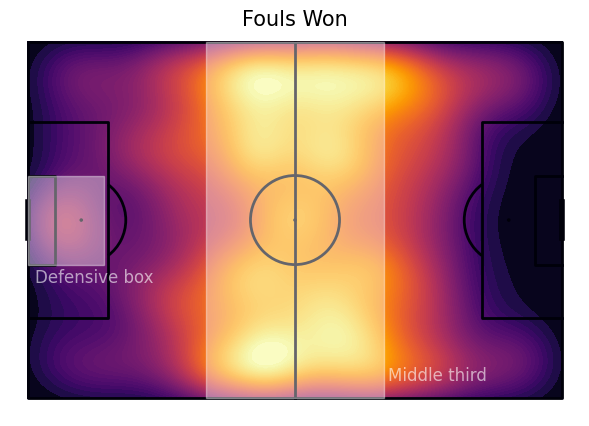

In [12]:
df_filtered = df_event.copy()

# filtering and aggregating data for Foul Won events
df_filtered = df_filtered.loc[df_filtered['type.name'] == 'Foul Won']
df_filtered['location_x'], df_filtered['location_y'] = extract_location(df_filtered['location'])  # location

# visualising
pitch = Pitch(line_color='#000009', line_zorder=2)
fig, ax = pitch.draw(figsize=(6, 8))
kde = pitch.kdeplot(df_filtered['location_x'], df_filtered['location_y'], ax=ax,
                    fill=True,
                    levels=100,
                    thresh=0,
                    cut=4,
                    cmap='inferno')


# highlighting areas
shape1 = np.array([[40, 0], [40, 80], [80, 80], [80, 0]])
shape2 = np.array([[0, 30], [17, 30], [17, 50], [0, 50]])
verts = [shape1, shape2]
pitch.polygon(verts, color='white', alpha=0.4, ax=ax, zorder=4)

txt = ax.text(x=92, y=75, s='Middle third', size=12, color='white', alpha=0.6,
              va='center', ha='center')

txt = ax.text(x=15, y=53, s='Defensive box', size=12, color='white', alpha=0.6,
              va='center', ha='center')

txt = ax.text(x=60, y=-5, s='Fouls Won', size=15, color='black', va='center', ha='center')


### Dropping unnecessary columns

In [23]:
cols_to_drop = [
    'Unnamed: 0',
    'index',
    'id',
    'timestamp',
    'second',
    'minute',
    'duration',  # extremely skewed
    'possession',
    'related_events',
    'location',
    'type.name',
    'possession_team.id',
    'possession_team.name',
    'play_pattern.name',
    'team.name',
    'tactics.formation',
    'tactics.lineup',
    'player.name',
    'position.name',
    'pass.height.name',
    'pass.body_part.name',
    'pass.type.name',
    'pass.outcome.name',
    'pass.outcome.id',  # Not known info at the time of ball reception or recovery
    'pass.receipient.id',
    'pass.recipient.name',
    'pass.end_location',
    'dribble.outcome.name',
    'ball_receipt.outcome.id',
    'ball_receipt.outcome.name',
    'carry.end_location',
    'duel.outcome.name',
    'competition_id',
    'match_id',
    'poss_mini',
    'poss_mini_id',
    'valid_start',
    'relevant_related_id',
    'location_related',
    'pass.end_location_related',  # same as location for the main event
    'id_related',
    'manager_id_home',
    'manager_id_away',
    'manager_countryid_home',
    'manager_countryid_away',
    'manager_birthdate_home',
    'manager_birthdate_away',
    'manager_birthdate_opponent',
    'manager_birthdate_own',
    'pass.end_location_y',
    'pass.end_location_x',
    'location_related_y',
    'location_related_x',
    # 'pass.end_location_y_bin',  # the event might come in with this
    # 'pass.end_location_x_bin',
]

df_training_full = df_training_full.drop(columns=cols_to_drop, errors='ignore')


### Using proper format for each columns

In [24]:
aaa = df_training_full.head(15)

In [26]:
df_training_full['duration'].skew()

np.float64(2.415114183608583)

# Notes MAGYARUL

- Arra figyelj, hogy az ID-kat ne számként értelmezze
- Figyelj arra, hogy ahol lehet ne hagy None-t, pl categorical-hoz mehet valami semleges category